# STAT 628 Module 2 BodyFat Group 3
#### Introduction: 
Our motivation is to obtain a precise, concise and reasonable regression model to predict body fat percentage of a male based on his body informations.
#### Dataset:
Our dataset ```BodyFat``` is a real data set of 252 men with measurements of their percentage of body fat and various body circumference measurements.
#### Background: 
We assume that percentage of body fat for an individual can be estimated once body density has been determined:
$$BodyFat(\%) = \frac{495}{BodyDensity(gm/cm^3)} - 450 \tag{1}$$
And the BMI can be calculated by:
$$BMI = \frac{703\times Weight(lbs)}{Height(inches)} \tag{2}$$

## 1. Exploratory data analysis

In [31]:
# install / import packages
usePackage = function(p) {
    if (!is.element(p,installed.packages()[,1]))
        install.packages(p, dep=TRUE)
    require(p, character.only=TRUE)
}

usePackage("ggplot2")
usePackage("Matrix")
usePackage("foreach")
usePackage("glmnet")
usePackage("MASS")

In [2]:
# Load the data
data = read.csv('BodyFat.csv')[,-1]
head(data)

BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12.6,1.0708,23,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
6.9,1.0853,22,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
24.6,1.0414,22,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
10.9,1.0751,26,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
27.8,1.0340,24,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
20.6,1.0502,24,210.25,74.75,26.5,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8


We can first intuitively analyze the data by looking at its summary tables and histograms. There are some obvious "abnormal" obsevations. Some results are as following:

    BODYFAT          WEIGHT          HEIGHT        ADIPOSITY    
 Min.   : 0.00   Min.   :118.5   Min.   :29.50   Min.   :18.10  
 1st Qu.:12.80   1st Qu.:159.0   1st Qu.:68.25   1st Qu.:23.10  
 Median :19.00   Median :176.5   Median :70.00   Median :25.05  
 Mean   :18.94   Mean   :178.9   Mean   :70.15   Mean   :25.44  
 3rd Qu.:24.60   3rd Qu.:197.0   3rd Qu.:72.25   3rd Qu.:27.32  
 Max.   :45.10   Max.   :363.1   Max.   :77.75   Max.   :48.90  

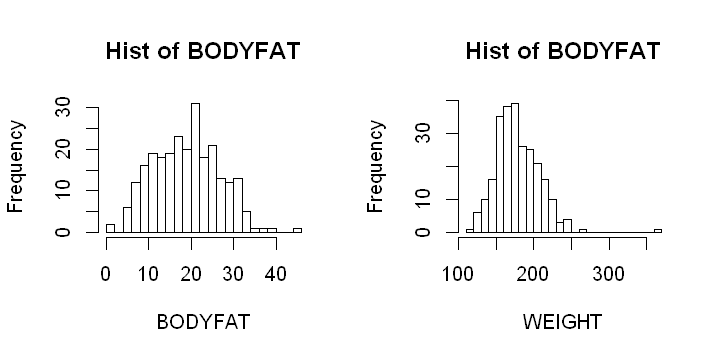

In [3]:
# summary and hist
summary(data[, c(1, 4, 5, 6)]) 
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow = c(1,2))
hist(data$BODYFAT, breaks = 30, main = "Hist of BODYFAT", xlab = "BODYFAT")
hist(data$WEIGHT, breaks = 30, main = "Hist of BODYFAT", xlab = "WEIGHT")
par(mfrow = c(1,1))

From the results above, we can find some "abnormal" obsevations: For example, the minimal ```BODYFAT``` is 0 %, which is unlikely to be true; besides, the maximal ```BODYFAT``` is 36 %, which is too large for a living person. Similarly, the minimal ```HEIGHT```, maximal ```WEIGHT``` and maxinal ```ADIPOSITY``` are all unlikely to be true for a nomal man. We can calculate the predicted values of these "abnormal" data using some formula or just delete these observations. Anyway, data cleaning is needed for this dataset.  

## 2. Data cleaning
To find out outliers, we can first look at the **boxplot:**

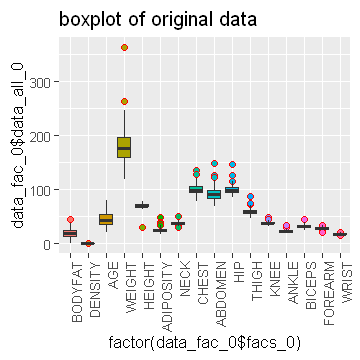

In [33]:
col_name = colnames(data)
n_row_0 = nrow(data)
n_col_0 = ncol(data)
# reshape the data into one-dim
data_all_0 = as.matrix(data)
dim(data_all_0) = c(n_row_0*n_col_0,1)
facs_0 = gl(n_col_0,n_row_0,label=col_name)
data_fac_0 = data.frame(data_all_0,facs_0)
# boxplot
box_0 = ggplot(data_fac_0,aes(x=factor(data_fac_0$facs_0),y=data_fac_0$data_all_0,fill = factor(data_fac_0$facs_0)))+
  geom_boxplot(outlier.color = "red",outlier.shape=21,outlier.size = 1.5)+
  labs(title = "boxplot of original data",xlab="factor",ylab="data value")+
  guides(fill=FALSE)+theme(text = element_text(size=10),axis.text.x = element_text(angle=90, hjust=1))
options(repr.plot.width=3, repr.plot.height=3)
box_0
# ggsave("boxplot_original.png",box_0)

Calculate the rages of ```WEIGHT```,```HEIGHT```,```DENSITY```,```BODYFAT``` between there 1% quantiles and 99% quantiles respectively, any value out of such ranges can be considered as "abnormal" observations:

In [5]:
weight_q = c(quantile(data$WEIGHT,0.01),quantile(data$WEIGHT,0.99))
#(125.505,245.720)
height_q = c(quantile(data$HEIGHT,0.01),quantile(data$HEIGHT,0.99))
#(64.3825 ,76.0000 )
density_q = c(quantile(data$DENSITY,0.01),quantile(data$DENSITY,0.99))
#(1.016040 ,1.095393)
bodyfat_q = c(quantile(data$BODYFAT,0.01),quantile(data$BODYFAT,0.99))
#(4.355 ,35.582)
print("Quantile ranges:")
quantiles = rbind(weight_q, height_q, density_q, bodyfat_q)
quantiles

[1] "Quantile ranges:"


,1%,99%
weight_q,125.50500,245.720000
height_q,64.38250,76.000000
density_q,1.01604,1.095393
bodyfat_q,4.35500,35.582000


We can then compare the body fat percentages calculated from formula (1) (```CalBodyFat```) and given by the dataset (```RealBodyFat```) of each observation to see if there is any strong difference. Similarly, we can compare the BMI values calculated from formula (2) (```CalBMI```) and given by the dataset (```RealBMI```) to find some outliers:

In [6]:
#Bodyfat & BMI from calculation
bodyfat_siri = (495/(data$DENSITY))-450
BMI_cal = (703*data$WEIGHT)/((data$HEIGHT)^2)
# compare the calculated results and the given values
compare_bodyfat = data.frame(RealBodyfat=data$BODYFAT,CalBodyfat=bodyfat_siri)
compare_BMI = data.frame(RealBMI=data$ADIPOSITY,CalBMI=BMI_cal)

### 2.1 For BMI:

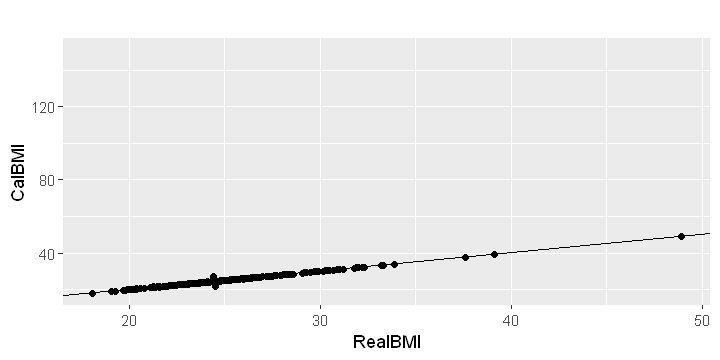

In [34]:
# plot the results
bmi_plot_1<- ggplot(compare_BMI,aes(x=RealBMI,y=CalBMI))+geom_point()+
  geom_abline(intercept = 0,slope = 1)+
  annotate("text",x=29.9,y=150.6,label="42",vjust=-1)+labs(title = "")
options(repr.plot.width=6, repr.plot.height=3)
bmi_plot_1
# ggsave("bmi_compare_1.png",bmi_plot_1)

The 42nd observation seems to be an outlier. Check his ```WEIGHT``` and ```HEIGHT``` to find out where is the problem:

In [8]:
paste("WEIGHT of 42nd observation: ", data[42,]$WEIGHT)
paste("Quantiles of WEIGHT: ")
weight_q
paste("HEIGHT of 42nd observation: ", data[42,]$HEIGHT)
paste("Quantiles of HEIGHT: ")
height_q

[1] "WEIGHT of 42nd observation:  205"

[1] "Quantiles of WEIGHT: "

1%     99% 
125.505 245.720

[1] "HEIGHT of 42nd observation:  29.5"

[1] "Quantiles of HEIGHT: "

1%     99% 
64.3825 76.0000

From the results above, we can see that the *42nd* observation’s height (**29.5** inches) is out of quantile range, so we use the formula (2) to calculated the height based on his weight and BMI, it turns out that his height should be **69.43** inches:

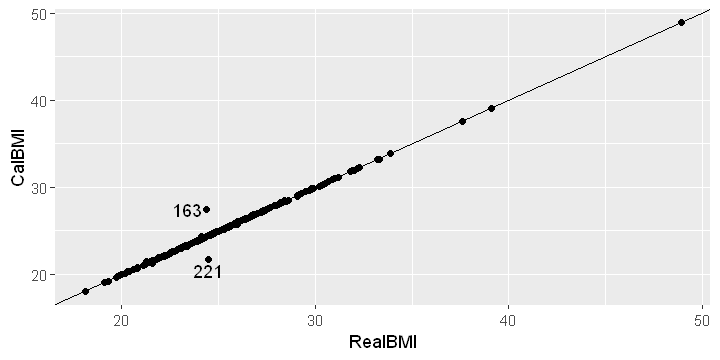

In [35]:
# replace the height of the 42nd obs
data_new = data
data_new$HEIGHT[42] = sqrt(703*(data$WEIGHT[42])/data$ADIPOSITY[42])
#after changing the height of point 42
compare_BMI$CalBMI[42]<- (703*data_new$WEIGHT[42])/((data_new$HEIGHT[42])^2)
bmi_plot_2<- ggplot(compare_BMI,aes(x=RealBMI,y=CalBMI))+geom_point()+
  geom_abline(intercept = 0,slope = 1)+
  annotate("text",x=23.4,y=25,label="163",vjust=-1)+
  annotate("text",x=24.5,y=18,label="221",vjust=-1)
options(repr.plot.width=6, repr.plot.height=3)
bmi_plot_2
# ggsave("bmi_compare_2.png",bmi_plot_2)

After changing the height of the *42nd* observation, we can find that the 163rd and 221st observations still don't fit the line perfectly, but after similar analysis, we find out that their heights and weights is within the quantile range above, so we won’t change them.

### 2.2 For BodyFat:

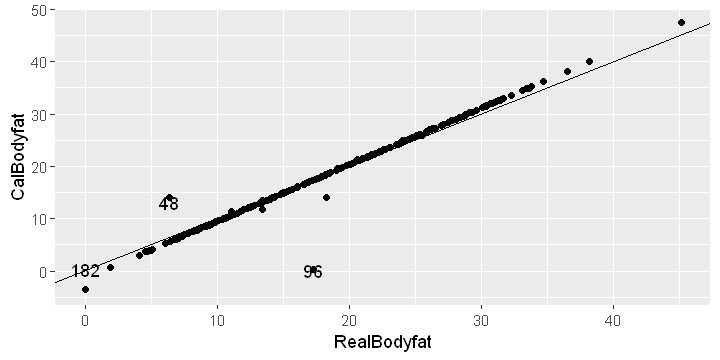

In [36]:
#compare BodyFat, plot the results
bodyfat_plot_1<- ggplot(compare_bodyfat,aes(x=RealBodyfat,y=CalBodyfat))+geom_point()+
  geom_abline(intercept = 0,slope = 1)+
  annotate("text",x=6.4,y=9,label="48",vjust=-1)+
  annotate("text",x=17.3,y=-4,label="96",vjust=-1)+
  annotate("text",x=0,y=-3.7,label="182",vjust=-1)
options(repr.plot.width=6, repr.plot.height=3)
bodyfat_plot_1
# ggsave("bodyfat_compare.png",bodyfat_plot_1)

In [11]:
# the data of abnormal observations
compare_bodyfat[c(182, 48, 96),]
myoutput = rbind(density = data$DENSITY[c(48,96)], bodyfat = data$BODYFAT[c(48,96)])
colnames(myoutput) = c("48th", "96th")
myoutput

,RealBodyfat,CalBodyfat
,<dbl>,<dbl>
182,0.0,-3.6116873
48,6.4,14.1350211
96,17.3,0.3684833


,48th,96th
density,1.0665,1.0991
bodyfat,6.4000,17.3000


From the graph above, we can see that the *182nd* observation have a **ZERO** calculated body fat percentage and a **NEGATIVE** given body fat percentage, which is unlikely to be true for a normal male, so, we will just remove this observation. The *48th* observation has normal body density and body fat percentage, so we will keep it in spite of its unfitness of the line. However, the *96th* obsrvation has a density far away from the density quantile range, so we should modify the body density of this observation or just drop this observation. Since people can not easily obtain body density in real life, we will just remove this observation (We also drop the column ```DENSITY``` since such data is not feasible in real world application): 

In [12]:
# we remove point 182 and 96; drop column DENSITY
data_new = data_new[-c(182,96),-2]

### 2.3 Other outliers
Finally, we use the 0.01 and 0.99 quantiles to replace the values out of 0.01 ~ 0.99 ranges and save the cleaned data into a ```.csv``` file:

In [13]:
#deal with other outlier
del_outliers = function(data,lower_b,upper_b){
  
  col_n = ncol(data)
  for(i in 1:col_n){
    temp = data[,i]
    q_lower = quantile(temp,lower_b)
    q_upper = quantile(temp,upper_b)
    data[temp < q_lower,i] = q_lower
    data[temp > q_upper,i] = q_upper
  }
  return(data)
}

data_new = del_outliers(data_new,0.01,0.99)
# write.csv(data_new,"cleaned.csv")

The **boxplot** of the cleaned data:

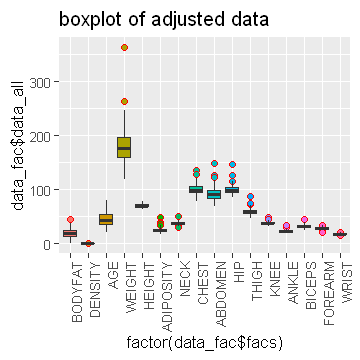

In [37]:
# boxplot of the cleaned data
data_all<- as.matrix(data_new)
dim(data_all)<- c(nrow(data_new)*ncol(data_new),1)
col_name_1<- colnames(data_new)
facs<- gl(ncol(data_new),nrow(data_new),label=col_name_1)
data_fac<- data.frame(data_all,facs)

box = ggplot(data_fac,aes(x=factor(data_fac$facs),y=data_fac$data_all,fill = factor(data_fac$facs)))+
  geom_boxplot(outlier.color = "red",outlier.shape=21,outlier.size = 1.5)+
  labs(title = "boxplot of adjusted data",xlab="factor",ylab="data value")+guides(fill=FALSE)+
  theme(text = element_text(size=10),axis.text.x = element_text(angle=90, hjust=1))
options(repr.plot.width=3, repr.plot.height=3)
box
# ggsave("boxplot_adjusted.png",box)

Obviously, there are less outliers after the data cleaning. Next, we will perform feature selection.

## 3. Feature Selection
### 3.1 Cross Validation
We use a **10-fold cross validation** to compute the average MSE (mean-square error) of each model:
$$MSE = E((Y - \hat{Y})^2) \tag{3}$$
We shuffle the data before every CV and repeated 1000 times.

In [15]:
#this is a function to calculate the cross validation
cv = function(data, model){
  num = dim(data)[1]
  var = dim(data)[2]
  l = round(n/10) # length of each fold
  MSE = 1:10
  for(i in 1:10){
    test = (l*(i-1)+1):(l*i)
    if(i == 10){
      test = (l*9+1):num
    }
    model = lm(model, data = data[-test,])
    test_X = data[test, 2:var]
    test_Y = data[test, 1]
    predict_Y = predict(model, test_X)
    MSE[i] = sum((test_Y - predict_Y)^2) / length(test_Y)
  }
  return(mean(MSE))
}

# repeat 10-fold CV 1000 times and then return the mean of MSE
FindCV = function(data,mymodel){
  n=nrow(data)
  cv_mean = 0
  for(i in 1:1000){
    shuffle = sample(1:n, n)
    model_cv = cv(data[shuffle,], mymodel)
    cv_mean = cv_mean + model_cv
  }
  cv_mean = cv_mean/1000
  return(cv_mean)
}

### 3.2 Stepwise model selection
Perform stepwise selections: We choose **AIC** and **BIC** methods:
Let k denote the number of parameters, let RSS denote the residual sum of squares, let n denote the number of observations, we have:  
** AIC (Akaike Information Criterion): **
$$AIC = 2k + n\ln{\frac{RSS}{n}} \tag{4}$$
Choose the model with minimal AIC.  
** BIC (Bayesian information criterion): **
$$BIC = k\ln{n} + n\ln{\frac{RSS}{n}} \tag{5}$$
Choose the model with minimal BIC.

In [16]:
#aic selection
model_full=lm(BODYFAT~.,data=data_new)
model_null=lm(BODYFAT~1, data=data_new)
aic_selection = step(model_null, scope=list(lower=model_null, upper=model_full), 
                     direction="both", trace=0, k = 2)$call$formula
print(aic_selection)

BODYFAT ~ ABDOMEN + WEIGHT + WRIST + AGE + THIGH + NECK + FOREARM


In [17]:
#bic selection
n = dim(data_new)[1]
bic_selection = step(model_full, direction = "both", trace = 0, k = log(n))$call$formula
print(bic_selection)

BODYFAT ~ AGE + ABDOMEN + WRIST + HEIGHT


### 3.3 LASSO
Let $\beta$ denote the parameters, we have:  
**LASSO** (least absolute shrinkage and selection operator) regression uses an objective function as:
$$f(\beta) = RSS_\beta + \lambda||\beta||_1 \tag{6}$$
Find the $\beta$ that minimizes $f(\beta)$. Since LASSO can force some parameters to become zero, we can use LASSO to perform feature selection.

In [18]:
#lasso
X = model.matrix(model_full)[,-1]
Y = data_new$BODYFAT
set.seed(123)
cv_lasso = cv.glmnet(X, Y, alpha = 1, family = "gaussian", nfolds = 10)
lasso.coef = coef(cv_lasso, s = cv_lasso$lambda.1se)
print(lasso.coef)

15 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) -10.81225367
AGE           0.02143009
WEIGHT        .         
HEIGHT       -0.23939696
ADIPOSITY     .         
NECK          .         
CHEST         .         
ABDOMEN       0.60378632
HIP           .         
THIGH         .         
KNEE          .         
ANKLE         .         
BICEPS        .         
FOREARM       .         
WRIST        -0.55902587


It is not difficult to find that **LASSO** and **BIC** methods give the same feature selection result. Then, we will fit and compare the AIC and BIC models.

### 3.4 Model Diagnostics
#### AIC model:
Summary:

In [19]:
#Diagnosis
fit_aic = lm(aic_selection, data=data_new)
summary(fit_aic) #r-squared:0.7418


Call:
lm(formula = aic_selection, data = data_new)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8430 -2.7203 -0.2356  2.6824  9.4297 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -27.18843    8.31921  -3.268  0.00124 ** 
ABDOMEN       0.79726    0.06489  12.286  < 2e-16 ***
WEIGHT       -0.08411    0.03249  -2.589  0.01022 *  
WRIST        -1.46874    0.47575  -3.087  0.00226 ** 
AGE           0.07042    0.02827   2.491  0.01342 *  
THIGH         0.22036    0.10582   2.083  0.03834 *  
NECK         -0.33554    0.21112  -1.589  0.11329    
FOREARM       0.37317    0.19006   1.963  0.05074 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.876 on 242 degrees of freedom
Multiple R-squared:  0.7418,	Adjusted R-squared:  0.7344 
F-statistic: 99.33 on 7 and 242 DF,  p-value: < 2.2e-16


**Diagnostic plots:**

In [20]:
# save the plot
png(filename="aic.png")
par(mfrow = c(2,2))
plot(fit_aic)
par(mfrow = c(1,1))
dev.off()

png 
  2

**CV MSE:**

In [22]:
# CV MSE for AIC model
aic_cv_mean = FindCV(data_new,aic_selection)
paste("CV MSE for AIC model: ", aic_cv_mean)

[1] "CV MSE for AIC model:  15.4708836965418"

**Box-Cox:**   
Test if we need a transformation or not

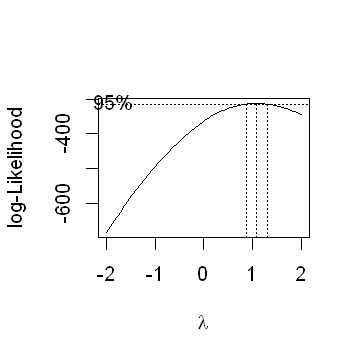

In [21]:
boxcox(fit_aic)

#### BIC model:
Summary:

In [23]:
fit_bic = lm(bic_selection,data=data_new)
summary(fit_bic) #r-squared:0.7336


Call:
lm(formula = bic_selection, data = data_new)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5911 -2.8493 -0.3755  2.9539  8.8630 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.94338    7.67578   0.383   0.7017    
AGE          0.05205    0.02212   2.353   0.0194 *  
ABDOMEN      0.69798    0.03072  22.721  < 2e-16 ***
WRIST       -1.71840    0.38130  -4.507 1.02e-05 ***
HEIGHT      -0.27799    0.11486  -2.420   0.0162 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.913 on 245 degrees of freedom
Multiple R-squared:  0.7336,	Adjusted R-squared:  0.7293 
F-statistic: 168.7 on 4 and 245 DF,  p-value: < 2.2e-16


**Diagnostic plots:**

In [24]:
# save the plot
png(filename="bic.png")
par(mfrow = c(2,2))
plot(fit_bic)
par(mfrow = c(1,1))
dev.off()

png 
  2

**CV MSE:**

In [25]:
bic_cv_mean = FindCV(data_new,bic_selection)
paste("CV MSE for BIC model: ", bic_cv_mean)

[1] "CV MSE for BIC model:  15.6645935313245"

**Box-Cox:**  
Test if we need a transformation or not

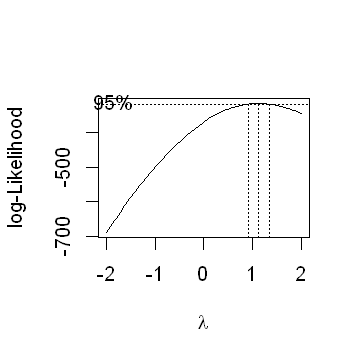

In [26]:
boxcox(fit_bic)

In [27]:
confint.lm(fit_bic,level = 0.95)

,2.5 %,97.5 %
(Intercept),-12.175559711,18.06231134
AGE,0.008486528,0.09562201
ABDOMEN,0.637470941,0.75848683
WRIST,-2.469449727,-0.96735232
HEIGHT,-0.504225995,-0.05176167


### 3.6 Other Models
We also try some other models which we think might be useful:  
$$1st : BODYFAT \sim WEIGHT + ABDOMEN$$
$$2nd : BODYFAT \sim ABDOMEN:WEIGHT$$
$$3rd : BODYFAT \sim ABDOMEN$$

Why we try these models:
Since by using AIC, BIC, LASSO to select variables, the model according to BIC selection is still with 4 variables, so according to the correlation of bodyfat and other variables, abdomen and weight have relatively higher correlation, so we will try to use this two variables and build other models to see what happen.

In [28]:
#try other models
model_1 = BODYFAT ~ WEIGHT + ABDOMEN
fit_model_1 = lm(model_1,data=data_new)
rsq_1 = summary(fit_model_1)$r.squared
model1_cv = FindCV(data_new, model_1)

model_2 = BODYFAT ~ ABDOMEN:WEIGHT
fit_model_2 = lm(model_2,data=data_new)
rsq_2 = summary(fit_model_2)$r.squared
model2_cv = FindCV(data_new, model_2)

model_3 = BODYFAT ~ ABDOMEN
fit_model_3 = lm(model_3,data=data_new)
rsq_3 = summary(fit_model_3)$r.squared
model3_cv = FindCV(data_new, model_3)

# model informations
rsq = c(rsq_1, rsq_2, rsq_3)
cv_mse = c(model1_cv, model2_cv, model3_cv)
other_models = data.frame(ID = c("1st", "2nd", "3rd"), R_square = rsq, CV_MSE = cv_mse)
other_models

ID,R_square,CV_MSE
<fct>,<dbl>,<dbl>
1st,0.7180885,16.26025
2nd,0.5292770,26.92585
3rd,0.6785452,18.37374


The 1st model has the minimal CV_MSE, choose this one to perform Diagnostics:

In [29]:
# for the 1st model
# save the plot
png(filename="1st.png")
par(mfrow = c(2,2))
plot(fit_model_1)
par(mfrow = c(1,1))
dev.off()

png 
  2

In [30]:
confint.lm(fit_model_1,level = 0.95)

,2.5 %,97.5 %
(Intercept),-46.3980258,-36.81650491
WEIGHT,-0.1541881,-0.07687099
ABDOMEN,0.7758684,0.98002118


### 3.7 Summary
1. The **R-squared** and **CV_MSE** of **AIC model** and **BIC model** are very close, so we will choose **BIC model** because it contains with less predictors.  
2. Among the three new models, the **1st** model has minimal **CV_MSE**, so, we think this model is also a good choise.
2. From the residual plots we can see that linearity and equal variance assumptions are satisfied for both **BIC** model and **1st** model, because the residual points are evenly distributed on both sides of the line and they are both very close to the x-axis.  
3. From the QQ plots, we can see that mornality assumptions are satisfied for both **BIC** model and **1st** model.
4. From the cook’s distances in the residuals vs leverage plots, we can assume there is no outlier.

### 4. Strength & weakness
#### 4.1 Strength
1. To deal with outliers, except for using the 2 formulas to correct or delete abnormal points, we also use 1% and 99% quantile of each variables to replace the value under or beyond these 2 quantiles, which is a reasonable way to reduce outliers.
2. We use Cross Validation to make our result more convincible.
3. Our two models are all linear, which are simple and with only 2 or 4 significant variables, which are all easy to measure.

#### 4.2 Weakness
1. For simplicity, the number of predictor variables are not enough.
2. The method we use to deal with outliers may to some extent hide the true situation of the sample.

### 5. Conclusion
Our final models are:
#### Model1 (Our Choise):
$$Model1: BODYFAT = -41.60 – 0.12\times WEIGHT + 0.88\times ABDOMEN$$  
**Possible rule of thumb**: "To calculate your body fat percentage, mutiply your ABDOMEN by 0.88, minus your WEIGHT multiplied by 0.12, then minus 41.60."
**Remarks**:  
All the variables are significant.  
With the cv MSE 16.26, R-Squared 0.7181.  

#### Model2 (An alternative model):
$$Model2: BODYFAT = 2.94 + 0.05\times AGE + 0.70*ABDOMEN -1.72\times WRIST -0.28\times HEIGHT$$  
**Remarks**:  
All the variables are significant.  
With the cv MSE 15.66, R-Squared 0.7336. 

### 6. Contribution
* Lingfeng ZHU: Implemented exploratory data analysis and copleted the Shiny App.
* Ruochen YIN: Completed presentation slides and presentation-related works.
* Jiahan LI: Implemented data cleaning and part of model diagnostic plots.
* Chong WEI: Implemented part of model selection and cross validation.